<a href="https://colab.research.google.com/github/gaurivn/Density-Based_Place_Clustering_Using_GeoSN_Data/blob/master/Location_Based_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=085a6f5e7c1484a398cc7048cc386f388c7187b0af6e93b8442b55fcd6c4dbd6
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
import numpy as np 
np.random.seed(1337)

import os
datadir = './data' 
if not os.path.exists(datadir):
  os.mkdir(datadir)

url = 'https://snap.stanford.edu/data/loc-gowalla_totalCheckins.txt.gz' 
filename = os.path.join(datadir, 'loc-gowalla_totalCheckins.txt.gz')

if not os.path.isfile(filename):
  import wget
  wget.download(url, out=filename)

####**Fetch and extract the required 'text' using regex from raw data and create a new file containing venues** 

In [6]:
## Fetch The venue names [2] in New York City 
from __future__ import unicode_literals
from importlib import reload
url = 'https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/locrec/gowalla-dataset.zip' 

src_filename = os.path.join(datadir, 'gowalla-dataset.zip')
trg_filename = os.path.join(datadir, 'gowalla_venues.csv') # data/gowalla_venues.csv
import sys
if sys.version[0] == '2':
  reload(sys)
  sys.setdefaultencoding("utf-8")
#import sys  
#reload(sys)  
#sys.setdefaultencoding('utf8')

if not os.path.isfile(trg_filename):
  import shutil
  import zipfile
  import re
  
  wget.download(url, out=src_filename)
  
  #extract
  zf = zipfile.ZipFile(src_filename, 'r')
  extracted_file = zf.extract('gowalla-dataset/spots.txt', datadir)
  tmp_filename = shutil.copy(extracted_file, datadir) #extracfile -> ./data/
  tmp_filename = "data/spots.txt"
  shutil.rmtree(os.path.dirname(extracted_file))
  
  #preprocess
  regex = re.compile(r'POINT\((\-?\d+\.\d+)\s+(\-?\d+\.\d+)\)')
  
  with open(tmp_filename, "r") as src,open(trg_filename, "w") as dst:
    next(src)
    for line in src:
      dst.write(regex.sub(r'\2\t\1', line))
      
  #cleanup
  os.remove(src_filename)
  os.remove(tmp_filename)

In [7]:
# The desired output looks something like:
!head -n 5 data/gowalla_venues.csv

1391604	Conference House Park	40.5017589436	-74.2523431778
1391611	Almer G. Russell Pavilion	40.5022647413	-74.2542636395
3612422	Conference House	40.5000644614	-74.2490418254
3612431	Billop House	40.5000644614	-74.2490418254
1391499	Biddle House	40.5054829933	-74.2541456223


### Data Preparation

In [8]:
import pandas as pd
import os
datadir = './data'
filename = os.path.join(datadir, 'loc-gowalla_totalCheckins.txt.gz')

df = pd.read_csv(filename, sep='\t', header=None)
df.columns = ['uid','timestamp','lat','lon','venue_id']
df.head()

,uid,timestamp,lat,lon,venue_id
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


In [9]:
df.shape

(6442892, 5)

#### Filtering new york city venues
##### The Flickr API provides us with the bounding box of the city. https://www.flickr.com/places/info/2459115

##### Bounding Box: -74.2589, 40.4774, -73.7004, 40.9176 Centroid: -74.0071, 40.7146

In [10]:
lon_min, lat_min, lon_max, lat_max = -74.2589, 40.4774, -73.7004, 40.9176

df = df[ (df['lon']>lon_min) & (df['lon']<lon_max) & (df['lat']>lat_min) & (df['lat']<lat_max) ]

df.head()

,uid,timestamp,lat,lon,venue_id
10,0,2010-10-12T00:21:28Z,40.643885,-73.782806,23261
11,0,2010-10-11T20:21:20Z,40.741374,-73.988105,16907
12,0,2010-10-11T20:20:42Z,40.741388,-73.989455,12973
13,0,2010-10-11T00:06:30Z,40.724910,-73.994621,341255
14,0,2010-10-10T22:00:37Z,40.729768,-73.998535,260957


In [11]:
df.shape

(138957, 5)

#### **Parse and localize date and time: UTC -> local**

In [12]:
import pytz as tz # better alternatives -> Apache arrow or pendulum
from datetime import datetime

def parse_datetime(s):
  tzone = tz.timezone("America/New_York")
  utc = datetime.strptime(s, '%Y-%m-%dT%H:%M:%SZ')
  return tz.utc.localize(utc).astimezone(tzone)

df['ts'] = df['timestamp'].apply(lambda x: parse_datetime(x))
df = df.drop('timestamp',axis=1,errors='ignore')

df['date'] = df['ts'].astype(object).apply(lambda x: x.date())
df['time'] = df['ts'].astype(object).apply(lambda x: x.time())
#day of the week (localtime) & hour of the day (localtime)
df['wd'] = df['date'].astype(object).apply(lambda x : x.weekday())
df['d'] = df['date'].astype(object).apply(lambda x : x.day)
df['h'] = df['time'].astype(object).apply(lambda x : x.hour)
df[['ts','date','time','wd','d','h']][0:3]

,ts,date,time,wd,d,h
10,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20
11,2010-10-11 16:21:20-04:00,2010-10-11,16:21:20,0,11,16
12,2010-10-11 16:20:42-04:00,2010-10-11,16:20:42,0,11,16


#### **Loading the venues data**

In [13]:
filename = os.path.join(datadir, 'gowalla_venues.csv')

dfv = pd.read_csv(filename, sep='\t', header=None)
dfv.columns = ['venue_id','name','lat','lon']
dfv.head()

,venue_id,name,lat,lon
0,1391604,Conference House Park,40.501759,-74.252343
1,1391611,Almer G. Russell Pavilion,40.502265,-74.254264
2,3612422,Conference House,40.500064,-74.249042
3,3612431,Billop House,40.500064,-74.249042
4,1391499,Biddle House,40.505483,-74.254146


#### **Joining Events with venues on venue ID**

In [14]:
# Will ignore events not in our venue id
df_merged = pd.DataFrame.merge(df, dfv[['venue_id']], on="venue_id", how="inner")
df_merged.head()

,uid,lat,lon,venue_id,ts,date,time,wd,d,h
0,0,40.643885,-73.782806,23261,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20
1,0,40.643885,-73.782806,23261,2010-10-07 11:27:40-04:00,2010-10-07,11:27:40,3,7,11
2,5,40.643885,-73.782806,23261,2010-08-15 23:47:20-04:00,2010-08-15,23:47:20,6,15,23
3,8,40.643885,-73.782806,23261,2010-10-06 16:23:14-04:00,2010-10-06,16:23:14,2,6,16
4,15,40.643885,-73.782806,23261,2010-10-13 00:10:36-04:00,2010-10-13,00:10:36,2,13,0


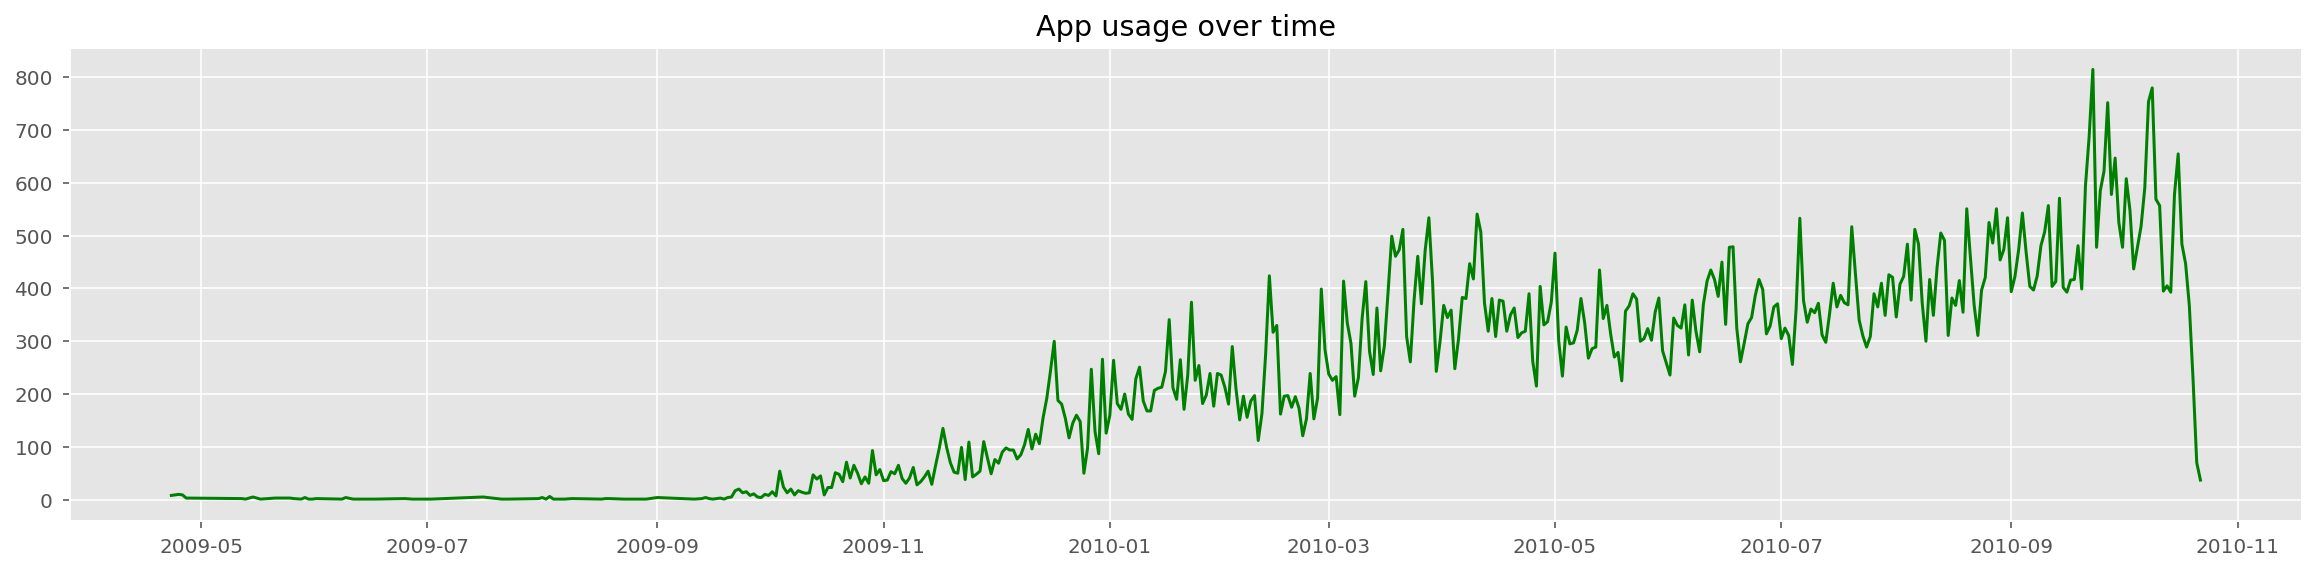

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
#import seaborn as sns
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 14})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

plt.subplot(4, 1, 1)
top = df_merged.groupby('date').size()
plt.plot(top.index, top, 'g-')
plt.title('App usage over time')
plt.show()

##### What is the distribution of events per hour of the day, per day of the week?
##### What is the histogram of the number of events registered per user?
##### Which are the most popular venues of all time?

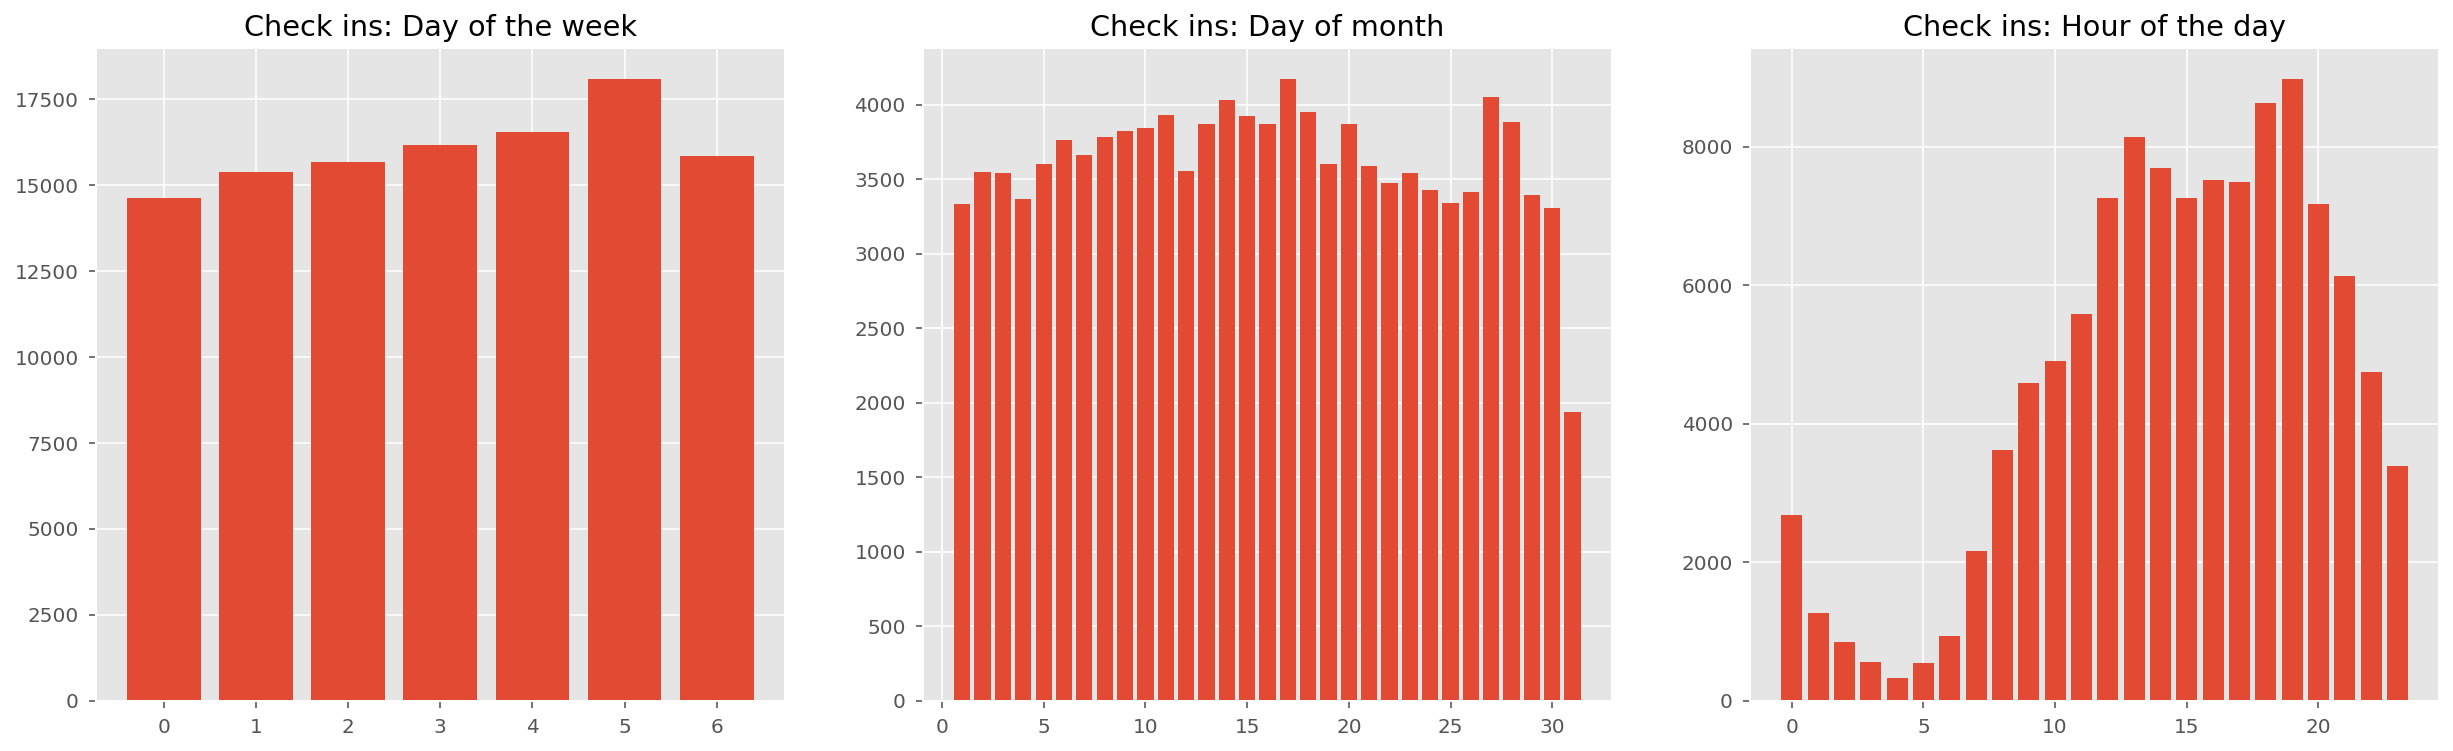

In [16]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,6)

plt.subplot(1,3,1)
events_per_hour = df_merged.groupby('wd').size()
plt.bar(events_per_hour.index, events_per_hour, align='center')
plt.title('Check ins: Day of the week')

plt.subplot(1,3,2)
day_month = df_merged.groupby('d').size()
plt.bar(day_month.index, day_month, align='center')
plt.title('Check ins: Day of month')

plt.subplot(1,3,3)
popular_venues = df_merged.groupby('h').size()
plt.bar(popular_venues.index, popular_venues, align='center')
plt.title('Check ins: Hour of the day')

plt.show()

##### The week seems to build up towards Saturday as the most popular day to record and share memorable events and venues. The end of the month has a surge of activities (most likely connected to people being happy to get their salaries). Finally, as expected, activity peaks during lunch and dinner times.

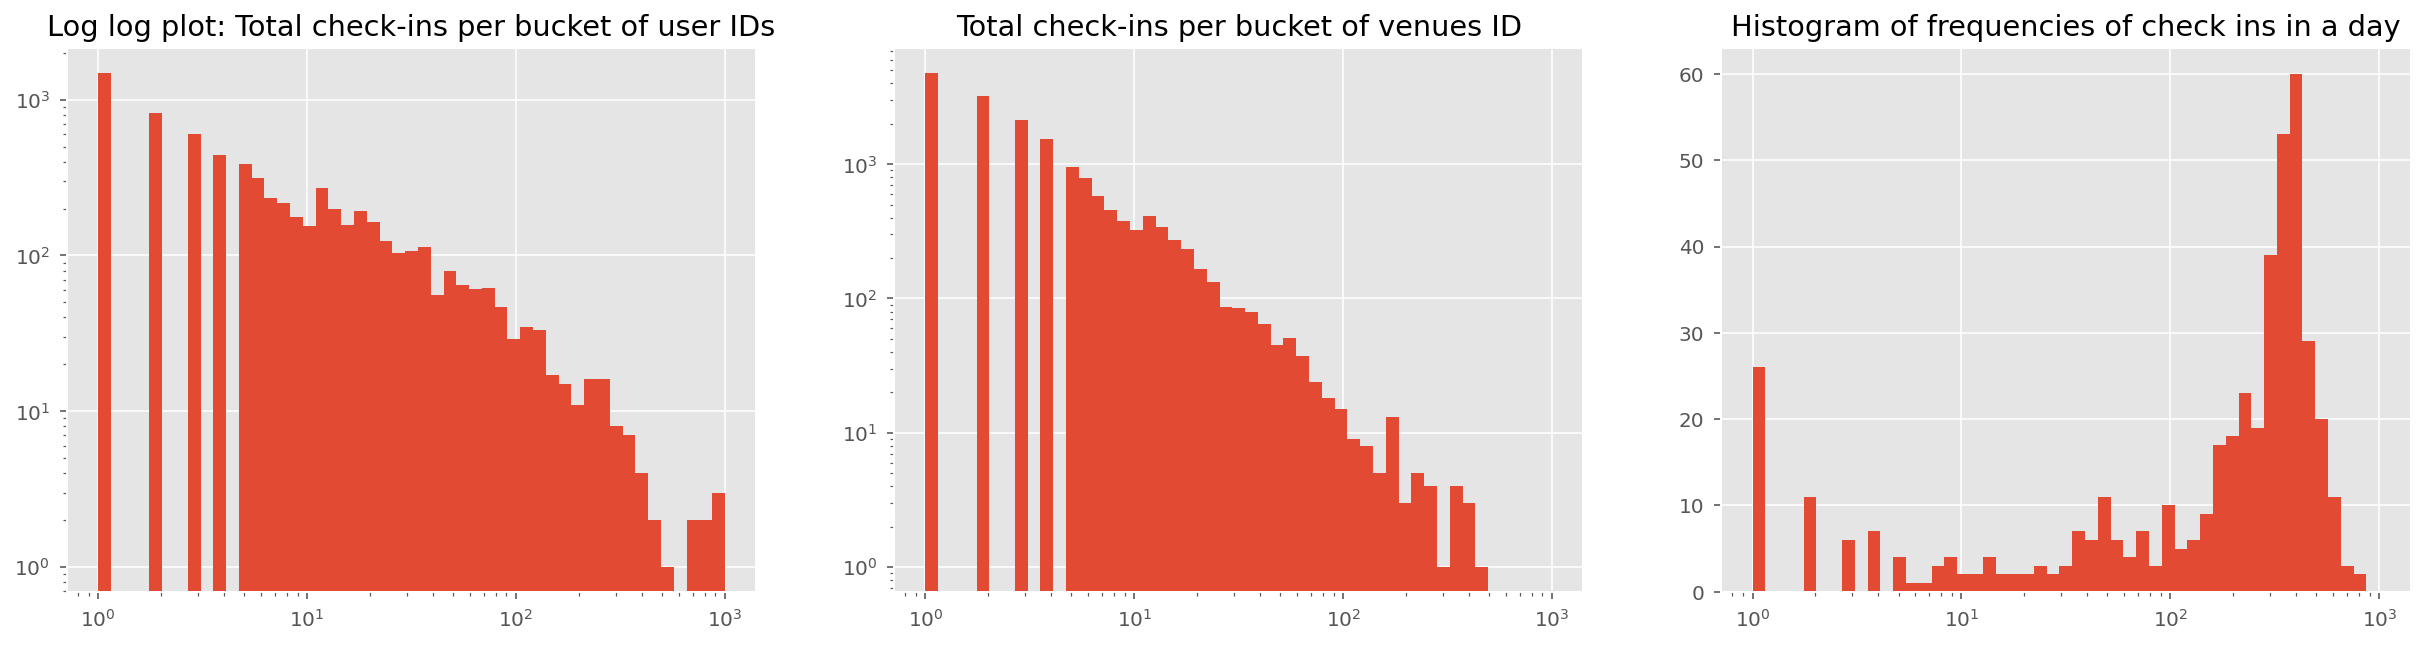

In [17]:
import numpy as np
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,5)
plt.subplot(1,3,1)
events_per_user = df_merged.groupby('uid').size()
plt.hist(events_per_user, bins=np.logspace(0,3,50))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.title('Log log plot: Total check-ins per bucket of user IDs')
plt.subplot(1,3,2)
venues = df_merged.groupby('venue_id').size()
plt.hist(venues, bins=np.logspace(0,3,50))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.title('Total check-ins per bucket of venues ID')
plt.subplot(1,3,3)
dates = df_merged.groupby('date').size()
plt.hist(dates, bins=np.logspace(0,3,50))
plt.gca().set_xscale("log")
plt.title('Histogram of frequencies of check ins in a day')
plt.show()

##### Both venues and users exhibit a zipf's law behavior, as shown above. Most of the registered users are related to small number of users and venues. The number of event registered are inversely related to the rank order. This applies to both the users as well as venues. The third histogram above shows that 60 is the most common number of events registered in a day in the city of New York

#### **Most common venues?**

In [18]:
common_venues = df_merged.groupby(['venue_id']).size()
dfv.join(common_venues.rename('count'), on='venue_id', how='inner').sort_values(by='count', ascending=False).head(10)

,venue_id,name,lat,lon,count
24140,12505,LGA LaGuardia Airport,40.774578,-73.872006,1680
5642,23261,JFK John F. Kennedy International,40.643885,-73.782806,1654
2165,24963,EWR Newark Liberty International,40.691247,-74.179516,1089
13382,11844,Times Square,40.756880,-73.986225,1089
18079,13022,Grand Central Terminal,40.752792,-73.977256,1005
9305,11875,Madison Square Garden,40.750614,-73.993435,430
19084,12525,The Museum of Modern Art (MoMA),40.761255,-73.977580,392
12880,12313,Empire State Building,40.748444,-73.985732,390
27189,11720,Yankee Stadium,40.829406,-73.927431,376
14487,11834,Bryant Park,40.753816,-73.983618,364


###### .. which makes sense. This initial analysis is a global cumulative analysis which does not take into account the fact that each area of the city has a specific dynamic. We could of course divide the city using an uniform grid, but this will not render justice to areas in Manhattan which are highly popular.

In [19]:
num_users = df_merged.groupby(['uid']).size().sort_values(ascending=False).head(10)
num_users

uid
578     1642
22      1290
842     1145
4985    1063
4902     968
4929     925
2798     919
3480     785
2964     779
1201     740
dtype: int64

In [20]:
!apt-get install -q libgeos-3.6.2
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
libgeos-3.6.2 is already the newest version (3.6.2-1build2).
libgeos-3.6.2 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (185 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1build2) ...


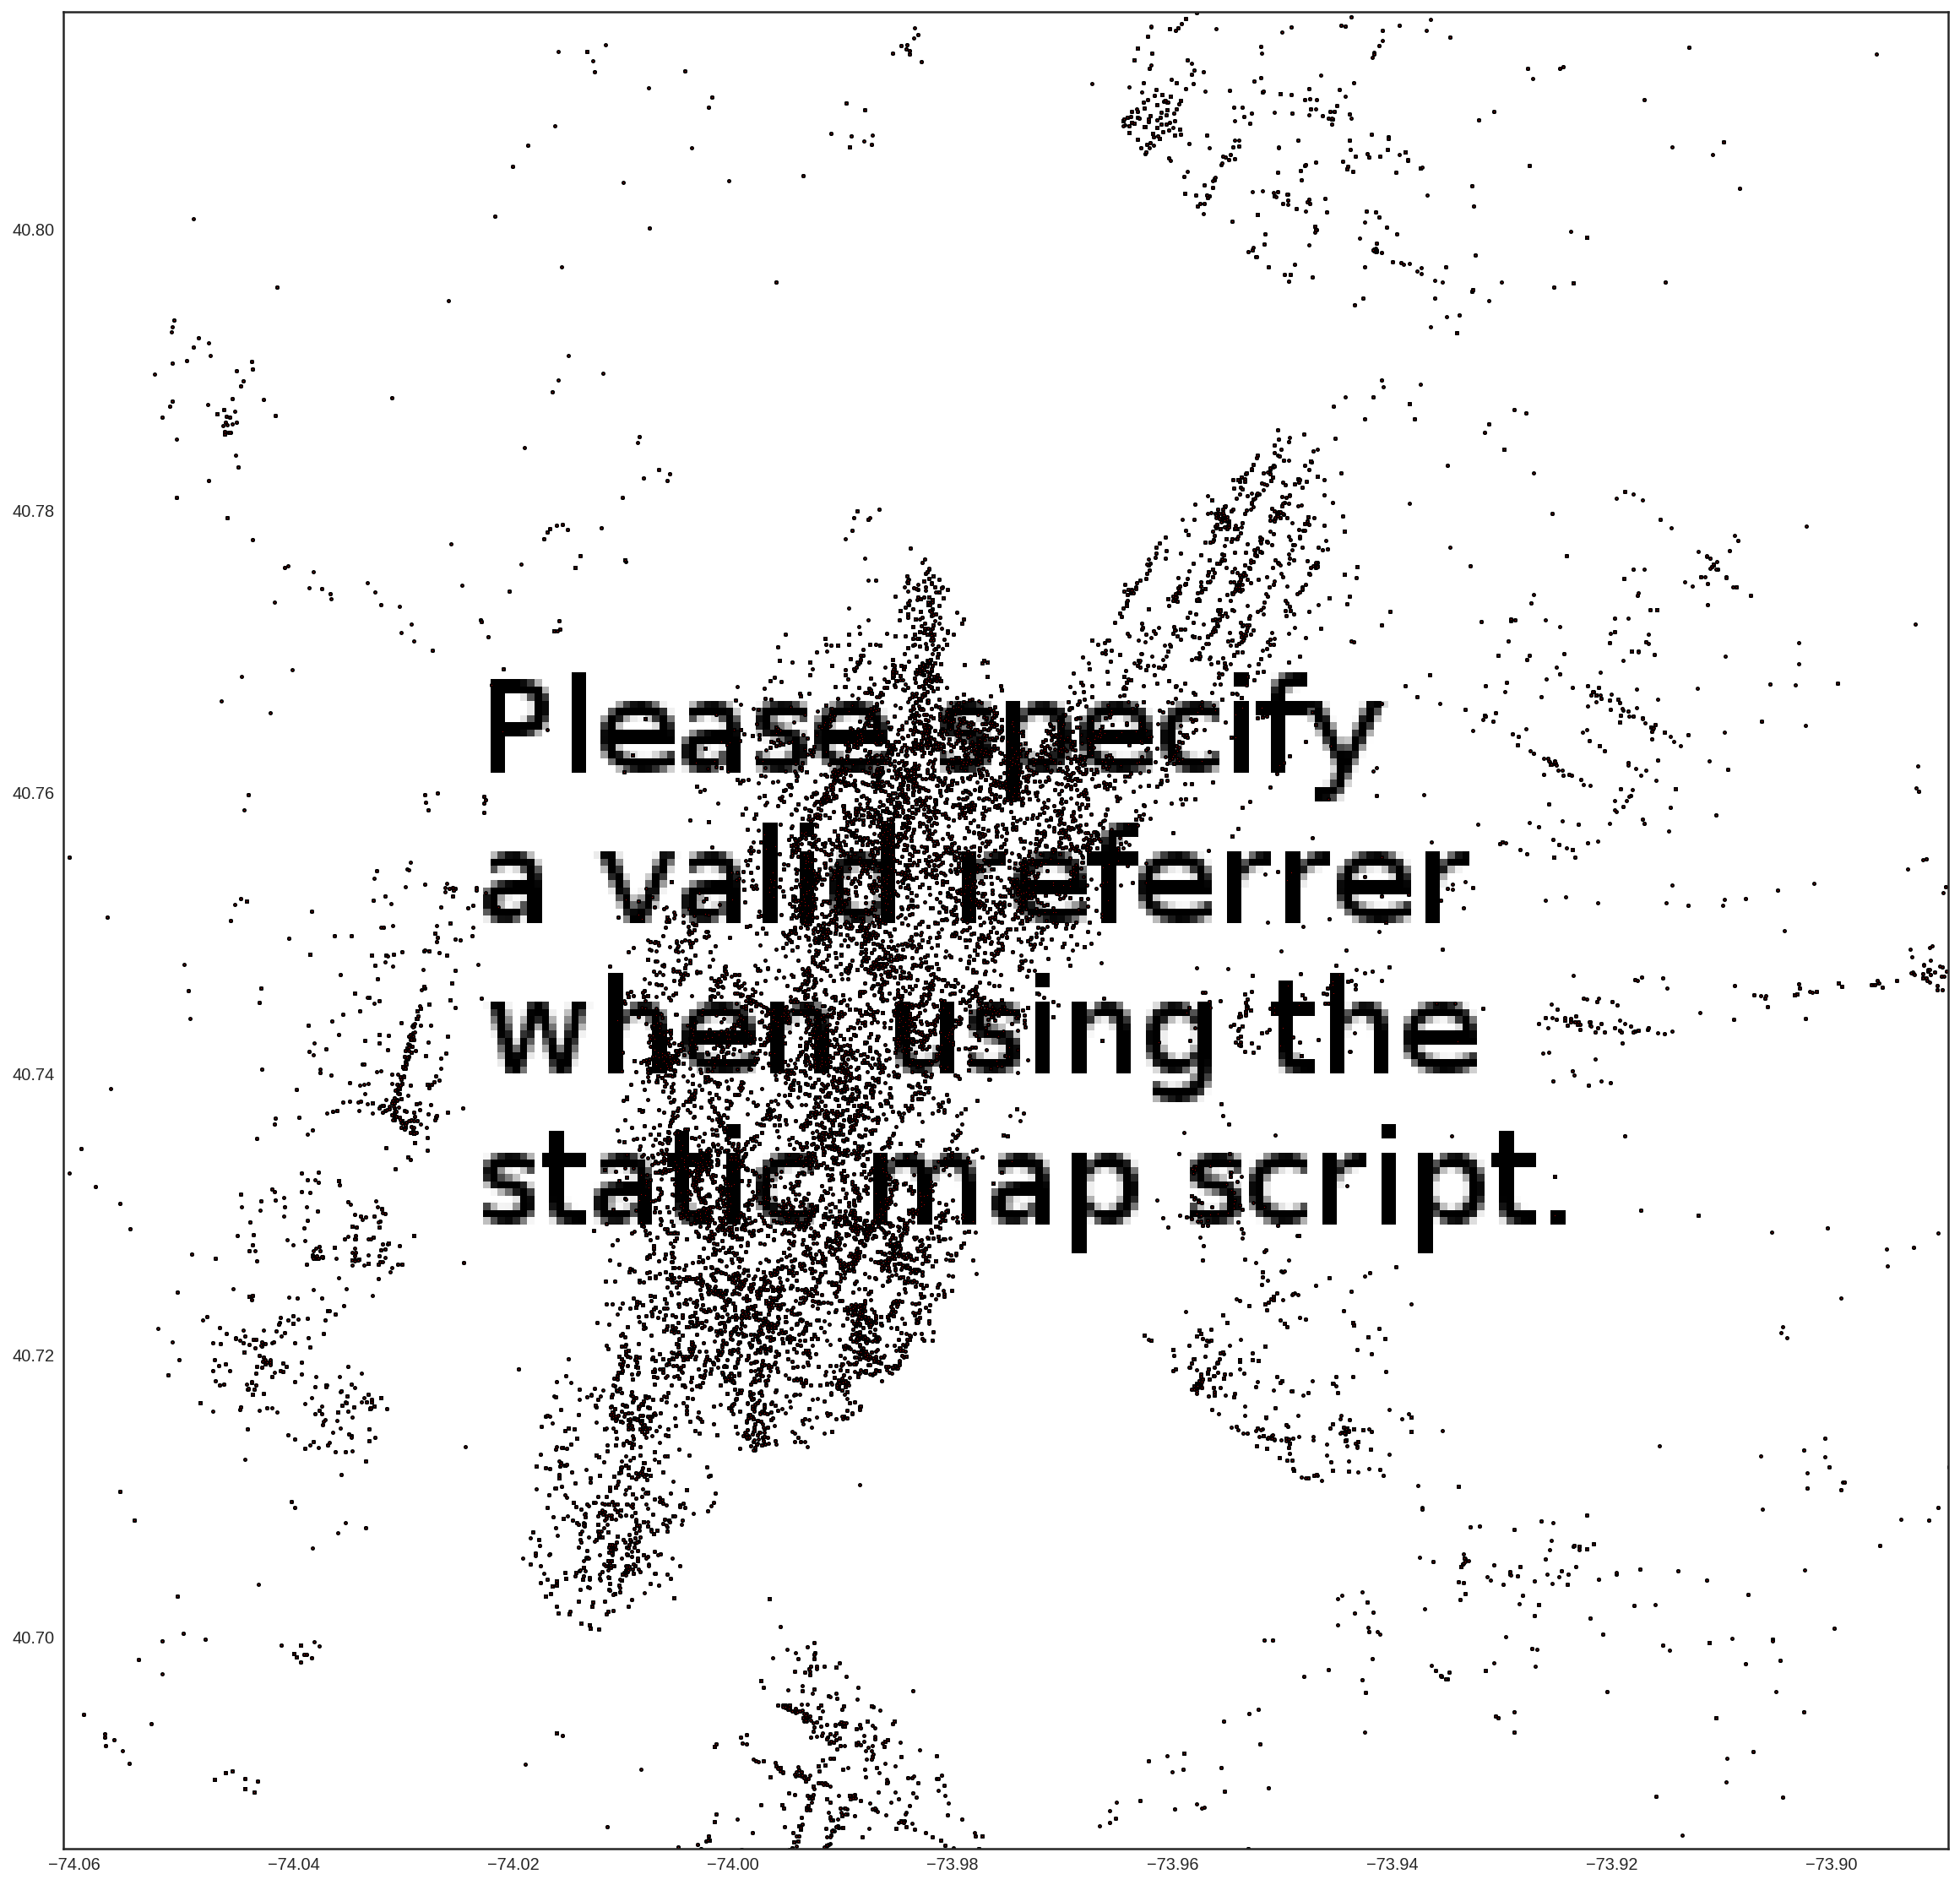

In [66]:
from PIL import Image
import urllib #.request
import wget
def get_map(x,y,z,size, filename):
  static_map = "http://staticmap.openstreetmap.de/staticmap.php?center={0},{1}&zoom={2}&size={3}x{3}&maptype=mapnik".format(y,x,z,size)
  #static_map = "https://staticmap.openstreetmap.de/staticmap.php?center=40.714728,-73.998672&zoom=14&size=865x512&maptype=mapnik"
  static_map_filename, headers = urllib.urlretrieve(static_map, filename)
  return static_map_filename

def geomap(data, zoom=13, point_size=3, point_color='r', point_alpha=1):
  #corrections to match geo with static map
  z=zoom
  picsize=1000
  wx = 1.0*360*(picsize/256)/(2**z) 
  wy = 0.76*360*(picsize/256)/(2**z) 
  
  #center of manhattan
  y = 40.7502
  x = -73.9752
  
  x_min, x_max = x-wx/2, x+wx/2
  y_min, y_max = y-wy/2, y+wy/2
  
  static_map_filename = os.path.join(datadir, 'nyc_staticmap_{}_{}.png'.format(z,picsize))
  
  if os.path.isfile(static_map_filename)==False:
    get_map(x,y,z,picsize,static_map_filename)
    
  img = Image.open(static_map_filename)
  
  #add the static map
  plt.imshow(img,zorder=0, extent=[x_min, x_max, y_min, y_max], interpolation='none', aspect='auto')
  
  #add the scatter plot of events
  plt.plot(
      data['lon'], 
      data['lat'], 
      '.', 
      markerfacecolor=point_color, 
      markeredgecolor='k', 
      markersize=point_size, 
      alpha=point_alpha)
  
  #limit the plot to the given box
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)

plt.style.use('seaborn-white')

fig = plt.figure()
fig.set_size_inches(20,20)

geomap(df_merged[['lon','lat']])

plt.show()

In [ ]:
!ls

data  sample_data


#### **Initializing k-means++ for unsupervised learning**

###### To note here, is how we are initializing with lots of clusters - assuming non-uniform distribution, can we expect equal number of points in each cluster? Probably not

In [28]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

ml = KMeans(n_clusters=200, init='k-means++')
ml.fit(df_merged[['lon', 'lat']].sample(frac=0.3))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=200, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [29]:
cluster = ml.cluster_centers_
cluster[:10]

array([[-74.00606317,  40.74125501],
       [-73.84837754,  40.72362617],
       [-74.1793275 ,  40.69157674],
       [-73.96740191,  40.76361886],
       [-73.99564901,  40.68280382],
       [-74.15922463,  40.89811013],
       [-73.78310005,  40.64385208],
       [-73.87259074,  40.77449174],
       [-73.90382376,  40.8794556 ],
       [-73.99063271,  40.7288124 ]])

In [30]:
df_merged['cluster'] = ml.predict(df_merged[['lon','lat']])
df_merged[['uid','lat','lon','venue_id','cluster']].sample(10)

,uid,lat,lon,venue_id,cluster
26710,125328,40.757831,-73.986086,48512,123
11401,4435,40.774578,-73.872006,12505,7
82063,153607,40.717511,-73.990108,36989,57
106608,36564,40.810303,-74.185189,1412206,13
26996,5862,40.729982,-74.000651,48017,64
8477,49988,40.675676,-74.000473,65864,4
27904,33332,40.687277,-74.182670,176536,2
82492,12876,40.747870,-74.003952,171954,108
55959,842,40.766214,-73.979599,1238205,28
65544,39399,40.775635,-73.982359,307999,105


###### I like to think of this like a uniform grid, but each grid cell is not the same size or shape. Can be any polygon. Also known as 'Voronoi'.

In [31]:
from scipy.spatial import Voronoi
def voronoi_polygons_2d(vor, radius=None):
  """
  Reconstruct infinite voronoi regions in a 2D diagram to finite 
  regions.
  
  Input_args:
  vor : Voronoi
      Input diagram
  radius : float, optional
      Distance to 'points at infinity'.

  :returns:
  regions : list of tuples
      Indices of vertices in each revised Voronoi regions.
  vertices : list of tuples
      Coordinates for revised Voronoi vertices. Same as coordinates
      of input vertices, with 'points at infinity' appended to the
      end.

  """
  if vor.points.shape[1] != 2:
    raise ValueError("Requires 2D input")
    
  new_regions = []
  new_vertices = vor.vertices.tolist()

  center = vor.points.mean(axis=0)
  if radius is None:
    radius = vor.points.ptp().max()*2

  # Construct a map containing all ridges for a given point
  all_ridges = {}
  for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
    all_ridges.setdefault(p1, []).append((p2, v1, v2))
    all_ridges.setdefault(p2, []).append((p1, v1, v2))

  # Reconstruct infinite regions
  for p1, region in enumerate(vor.point_region):
    vertices = vor.regions[region]
    
    if all([v >= 0 for v in vertices]):
      # finite region
      new_regions.append(vertices)
      continue

      # reconstruct a non-finite region
      ridges = all_ridges[p1]
      new_region = [v for v in vertices if v >= 0]
      
      for p2, v1, v2 in ridges:
        if v2 < 0:
          v1, v2 = v2, v1
        if v1 >= 0:
          # finite ridge: already in the region
          continue
          
        # Compute the missing endpoint of an infinite ridge
        
        t = vor.points[p2] - vor.points[p1] # tangent
        t /= np.linalg.norm(t)
        n = np.array([-t[1], t[0]])  # normal
        
        midpoint = vor.points[[p1, p2]].mean(axis=0)
        direction = np.sign(np.dot(midpoint - center, n)) * n
        far_point = vor.vertices[v2] + direction * radius
        
        new_region.append(len(new_vertices))
        new_vertices.append(far_point.tolist())

      # sort region counterclockwise
      vs = np.asarray([new_vertices[v] for v in new_region])
      c = vs.mean(axis=0)
      angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
      new_region = np.array(new_region)[np.argsort(angles)]
      
      # finish
      new_regions.append(new_region.tolist())
      
  return new_regions, np.asarray(new_vertices)

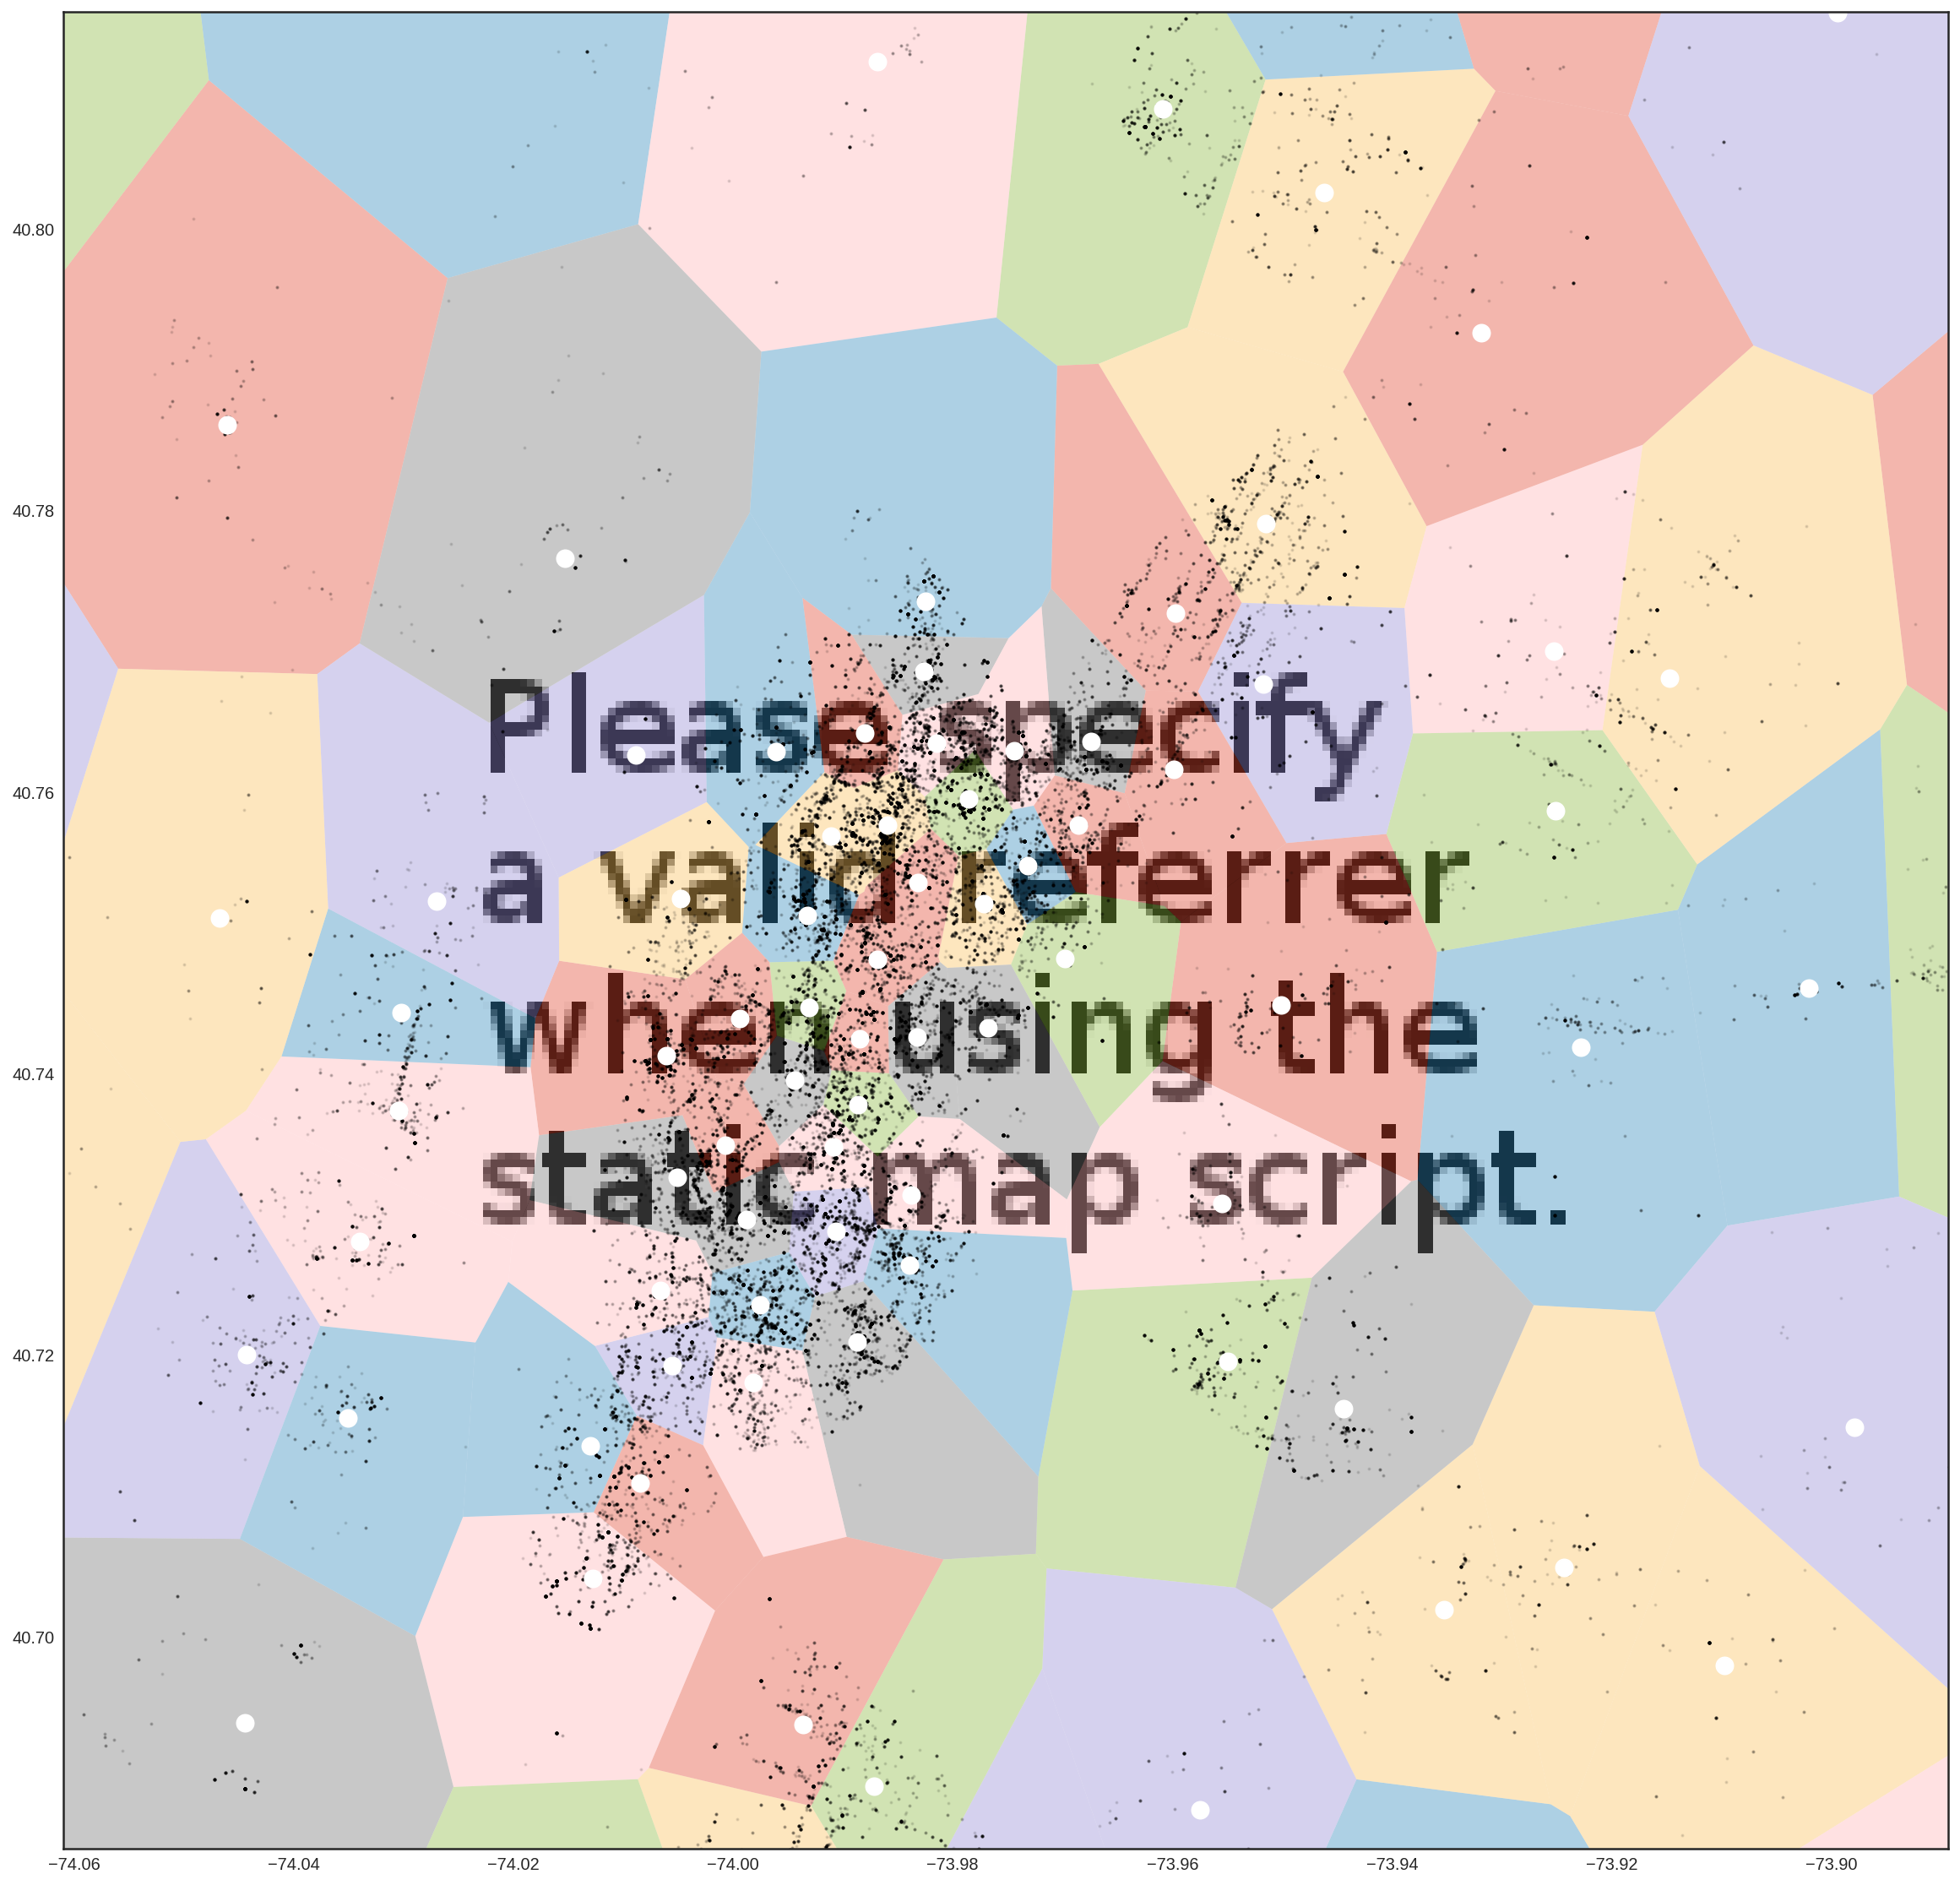

In [32]:
# points = np.array([[c[1], c[0]] for c in clusters])
points = cluster

# compute Voronoi tesselation
vor = Voronoi(points)

# compute regions
regions, vertices = voronoi_polygons_2d(vor)

# prepare figure
plt.style.use('seaborn-white')
fig = plt.figure()
fig.set_size_inches(20,20)

#geomap
geomap(df_merged[['lon','lat']], 13, 2,'k',0.1)

# centroids
plt.plot(points[:,0], points[:,1], 'wo',markersize=10)

# colorize
for region in regions:
  polygon = vertices[region]
  plt.fill(*zip(*polygon), alpha=0.4)

plt.show()

See how clusters are non-uniformly distributed - the reason for using high nums of clusters

Above we see a global check-in patterns all over new york. Let's refine this to see popular places within those grids/each clusters

In [33]:
global_df = df_merged.groupby(['cluster', 'venue_id']).size().reset_index()
global_df.columns = ['cluster', 'venue_id', 'count']

In [34]:
idx = global_df.groupby(['cluster'])['count'].transform(max) == global_df['count']
idx.head()

0    False
1    False
2    False
3    False
4    False
Name: count, dtype: bool

In [35]:
topvenues_df = global_df[idx].merge(dfv, on="venue_id", how="left").sort_values(by="count", ascending=False)

Here we see top 100 venues within each cluster:

In [36]:
top_10_df = topvenues_df[:10]
top_10_df

,cluster,venue_id,count,name,lat,lon
8,7,12505,1680,LGA LaGuardia Airport,40.774578,-73.872006
7,6,23261,1654,JFK John F. Kennedy International,40.643885,-73.782806
2,2,24963,1089,EWR Newark Liberty International,40.691247,-74.179516
132,123,11844,1089,Times Square,40.756880,-73.986225
45,43,13022,1005,Grand Central Terminal,40.752792,-73.977256
138,128,11875,430,Madison Square Garden,40.750614,-73.993435
37,35,12525,392,The Museum of Modern Art (MoMA),40.761255,-73.977580
31,29,12313,390,Empire State Building,40.748444,-73.985732
57,53,11720,376,Yankee Stadium,40.829406,-73.927431
93,89,11834,364,Bryant Park,40.753816,-73.983618


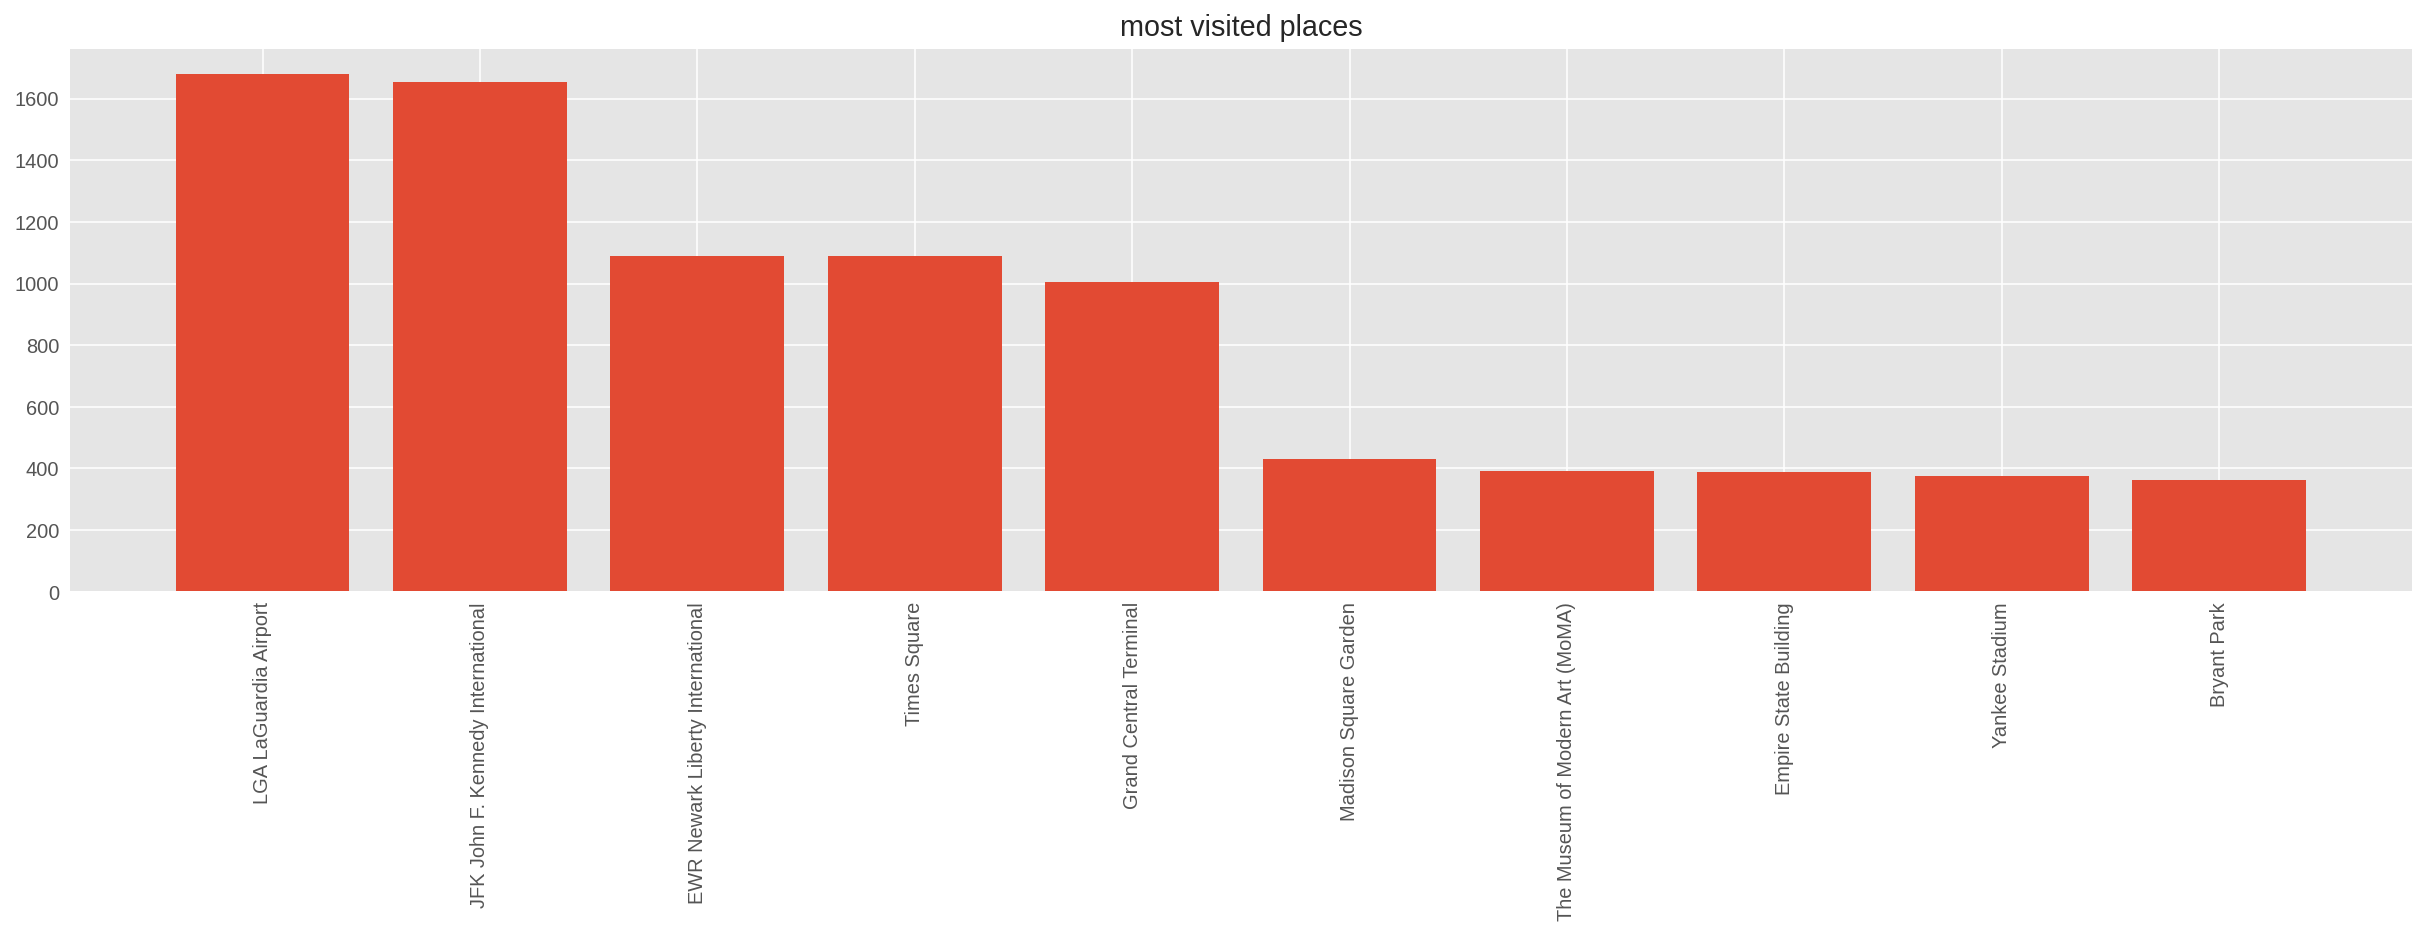

In [37]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21, 5)
plt.bar(range(len(top_10_df)), top_10_df['count'], align="center")
plt.xticks(range(len(top_10_df)), top_10_df['name'], rotation='vertical')
plt.title("most visited places")
plt.show()

### Aside: Small class for caching all requests

In [39]:
class CacheURL:
  def __init__(self, datadir=".", filename='CacheURL.cache.csv'):
    self.datadir=datadir
    self.filename = filename
    self.filepath = os.path.join(self.datadir, self.filename)
    if os.path.isfile(self.filepath):
      self.cached_req = pd.read_csv(self.filepath, sep="\t", index_col=None)
    else:
      self.cached_req = pd.DataFrame(columns=['url', 'response'])
      
  #set cache to False if you want to want to get fresh data from url        
  def get_body(self, url, cache=True):
    entries = self.cached_req[self.cached_req['url']==url]['response']
    if entries.empty or not cache:
      body = requests.get(url).json() # json string 
      #print "body is: ",body, type(body) ## Auto parsing the json as a list? 
      new_entry = pd.DataFrame(data=[[url, body]], columns=['url', 'response'])
      self.cached_req = self.cached_req.append(new_entry, ignore_index=True)
    else:
      body = entries.iloc[0]
    return body
        
  def cache(self):
    return self.cached_req.copy(deep=True)
    
  def save(self):
    self.cached_req.to_csv(self.filepath, sep="\t", index=False)

In [40]:
from IPython.core.display import display, HTML
import requests, json

c_url = CacheURL(datadir)

def get_wiki_url(text):
  text = requests.utils.quote(text)
  url = "https://en.wikipedia.org/w/api.php?action=opensearch&search={}&limit=1&format=json".format(text)
  resp = c_url.get_body(url) # resp should be a json returned from Cache url class instead its a list
  res = resp[3]
  return res

def recommendation_venue(df, lon, lat):
  cluster = ml.predict(np.array([lon, lat]).reshape(1, -1))[0]
  venue_name = df[df['cluster']==cluster].iloc[0]['name']
  url = get_wiki_url(venue_name) # return url on the wiki page
  if url:
    venue_html = '<a href="{}">{}</a>?'.format(url[0], venue_name)
  else:
    venue_html = venue_name
    
  msg = "What about visiting the {}".format(venue_html)
  return display(HTML(msg))

In [41]:
recommendation_venue(topvenues_df, -74.01, 40.7)

In [42]:
recommendation_venue(topvenues_df, -74, 40.72)

In [43]:
recommendation_venue(topvenues_df, -74, 40.55)

### **DBSCAN: Density based scanning algorithm**

##### **Moving from venues to users. This enables us to dig into domains of fraud detection, personlized marketing etc**

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. Read more on that here..
DBSCAN is better suited for datasets that have disproportional cluster sizes, and whose data can be separated in a non-linear fashion. Like K-means, DBSCAN is scalable, but using it on very large datasets requires more memory and computing power.

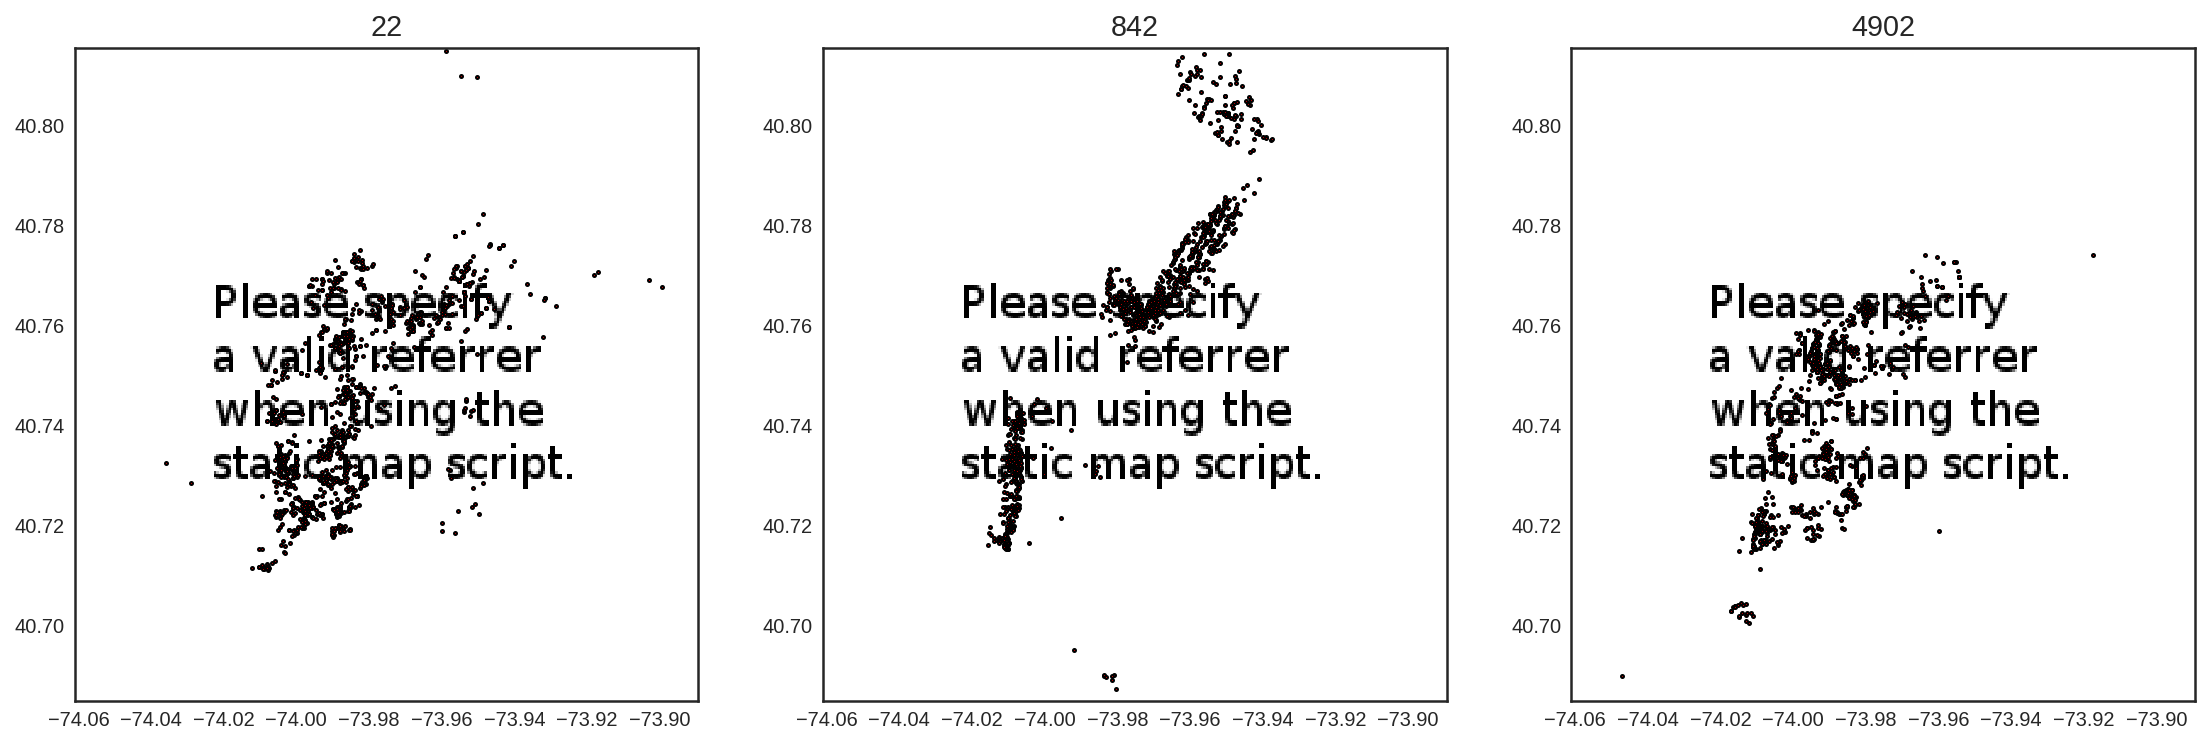

In [44]:
plt.style.use('seaborn-white')
fig = plt.figure()
fig.set_size_inches(19, 6)

plt.subplot(1, 3, 1)
geomap(df_merged[df_merged['uid'] == 22][['lon', 'lat']])
plt.title('22')

plt.subplot(1, 3, 2)
geomap(df_merged[df_merged['uid'] == 842][['lon', 'lat']])
plt.title('842')

plt.subplot(1, 3, 3)
geomap(df_merged[df_merged['uid'] == 4902][['lon', 'lat']])
plt.title('4902')
plt.show()

##### Users movement are usually clustered around some areas; specific users are checking in at specific places

##### **Let's define distance(eucilidean) as a measure of density**

In [45]:
from sklearn.cluster import DBSCAN
uid = 4902

#1deg at 40deg latitude is 111034.61 meters
#set radius at 300 mt
eps = 260/111034.61 #The maximum distance between two samples for them to be considered as in the same neighborhood.

data = df_merged[df_merged['uid']==uid][['lon','lat','venue_id']]
db = DBSCAN(eps=eps, min_samples=3, n_jobs=1).fit(np.array(data[['lon','lat']])) # atleast 3 points in a cluster

##### An interesting thing to note, machine learning algorithms like sklearn are taking lat lon as straight numbers unlike postgres extension "posGIS" which has this layer on top of these fields, which puts more meaning to spatial data like lat-long. Highly recommend using postGIS for providing end results

In [46]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
data['dbscan_cluster'] =  db.labels_
data['dbscan_core']    = core_samples_mask
print("# clusters: {}".format(len(set(data['dbscan_cluster']))))

# clusters: 21


In [47]:
data.head()

,lon,lat,venue_id,dbscan_cluster,dbscan_core
415,-73.782806,40.643885,23261,0,True
416,-73.782806,40.643885,23261,0,True
417,-73.782806,40.643885,23261,0,True
418,-73.782806,40.643885,23261,0,True
419,-73.782806,40.643885,23261,0,True


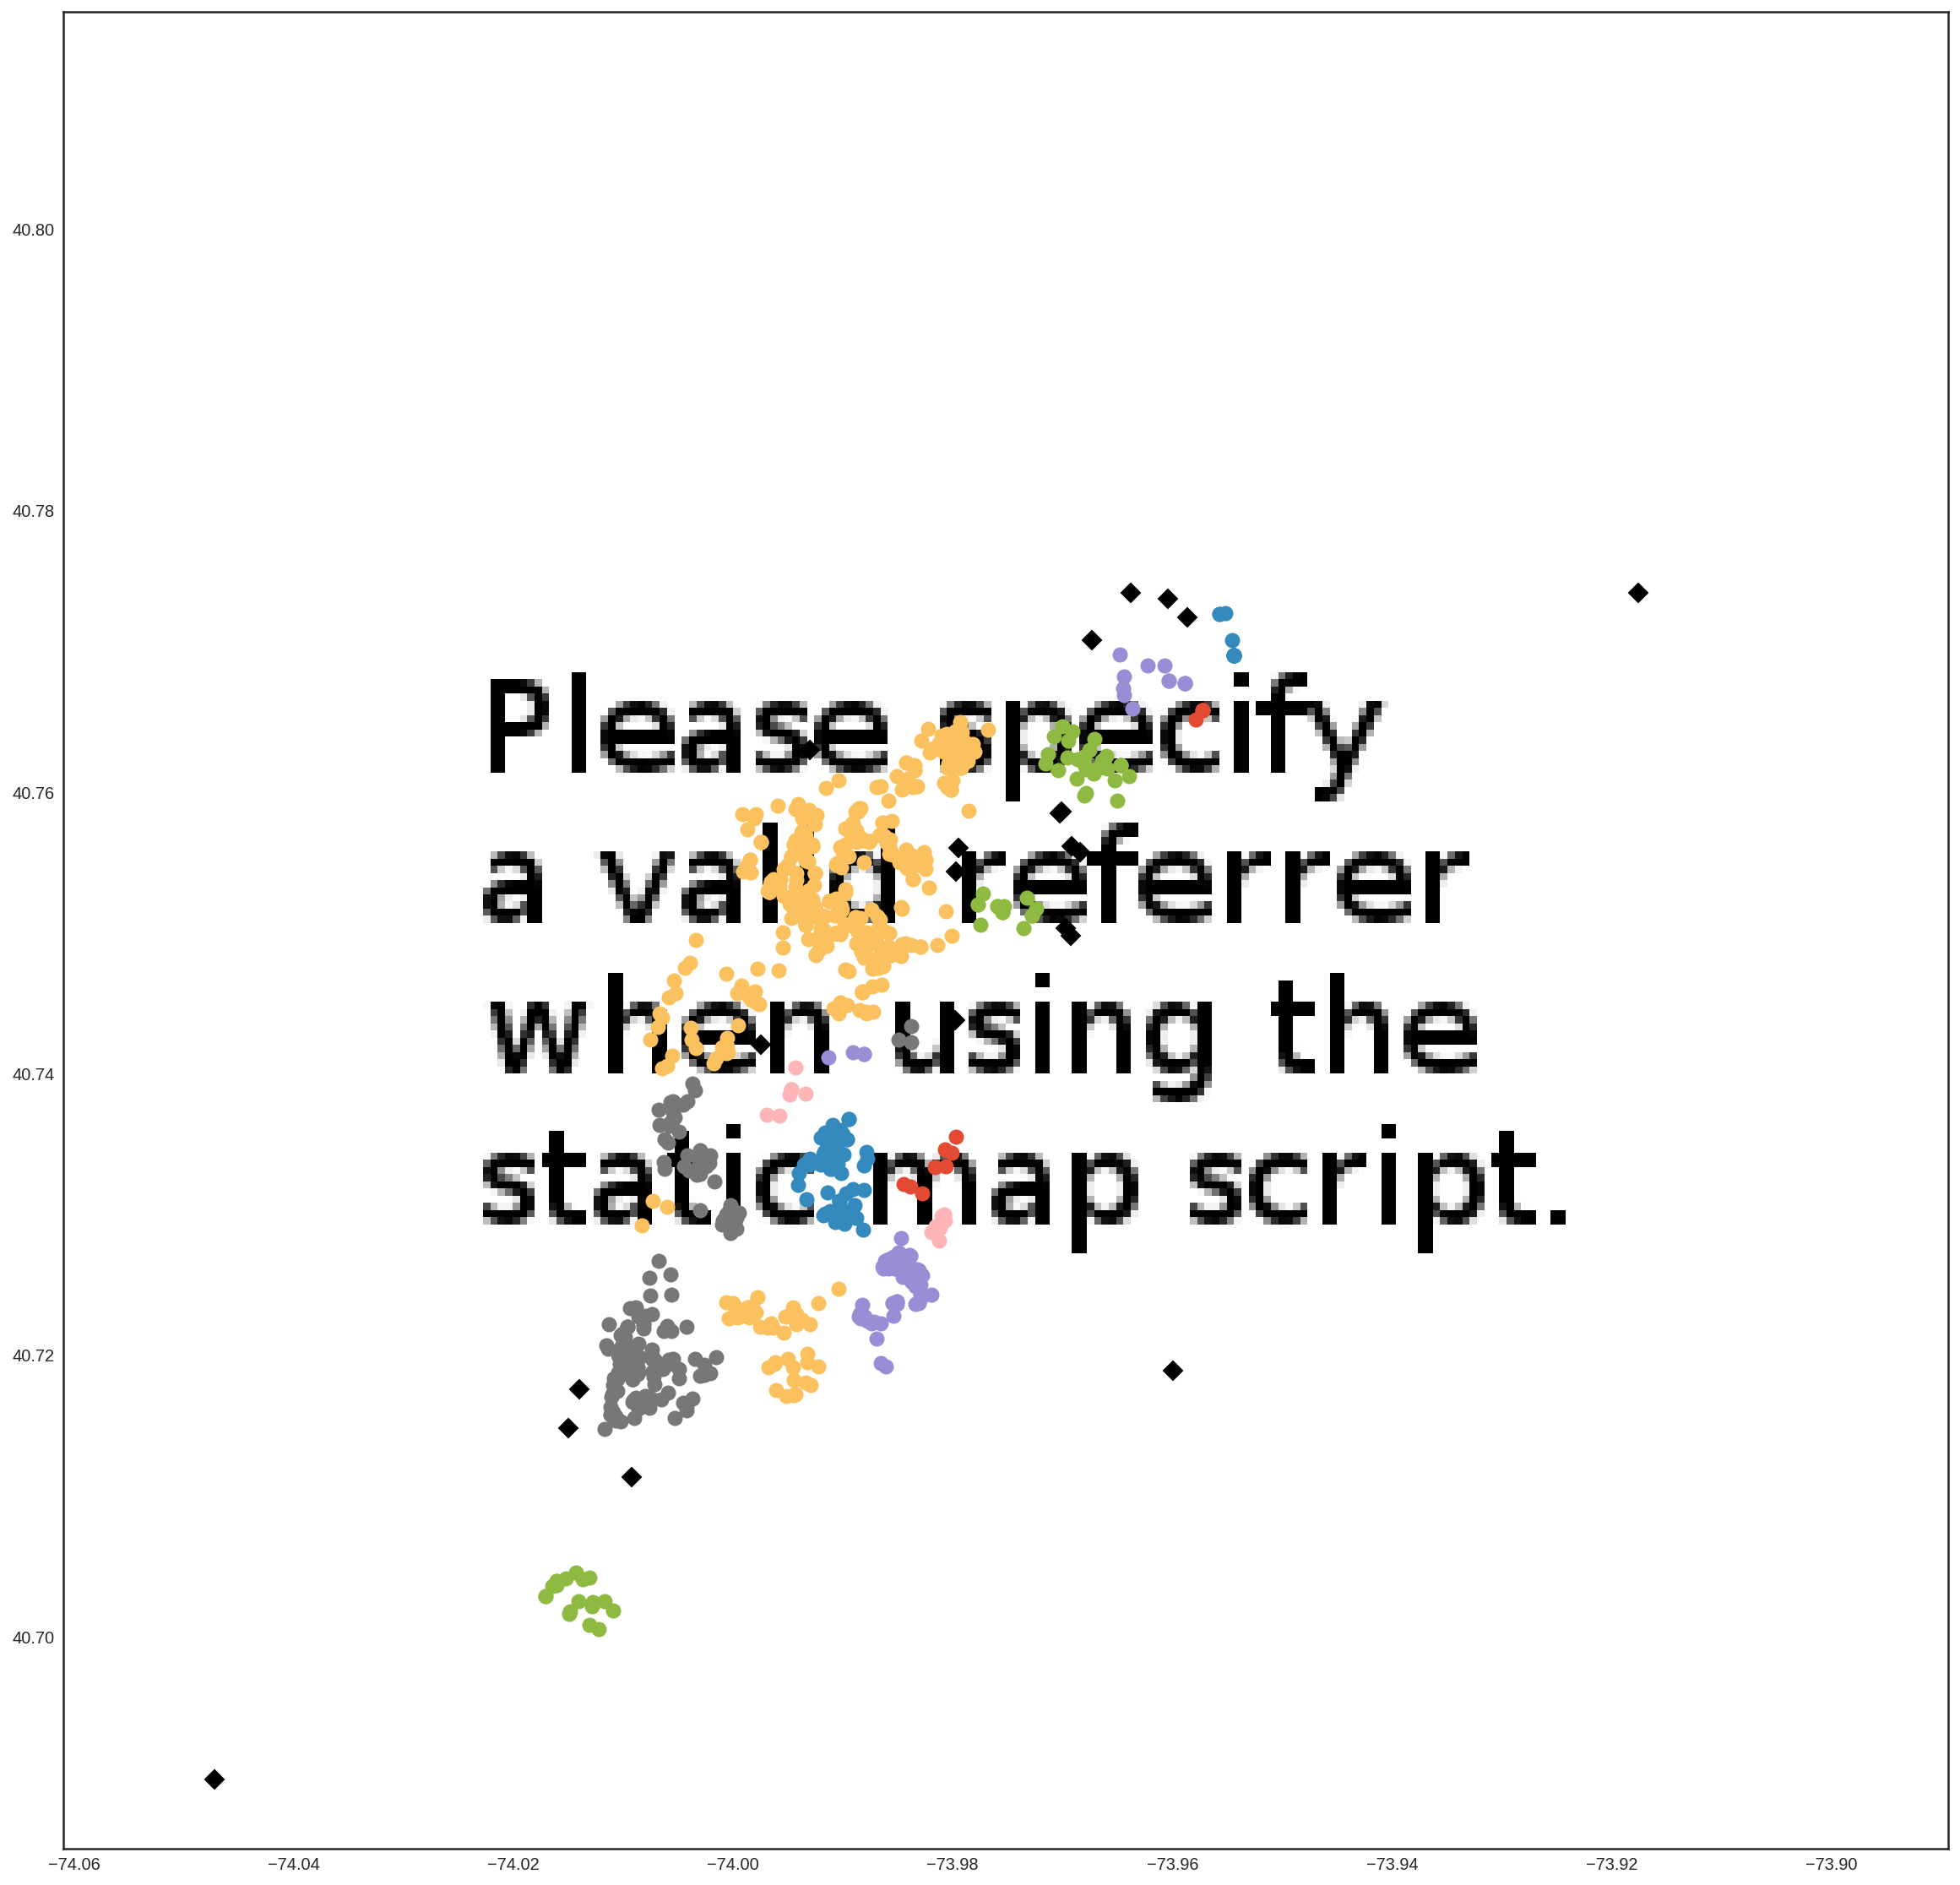

In [48]:
plt.style.use('seaborn-white')
fig = plt.figure()
fig.set_size_inches(20, 20)

empty = pd.DataFrame(columns=['lon', 'lat'])
geomap(empty, 13, 2, 'k', 0.1)

unique_labels = sorted(set(data['dbscan_cluster']))
for k in unique_labels:
  xy = data[data['dbscan_cluster']==k]
  plt.plot(xy['lon'], xy['lat'], 'kD' if k < 0 else 'o', markersize=8)
plt.show()

### Can be used for Early triggers from users behavior or personalized marketing - as these graphs are for one particular user(uid = 4902)

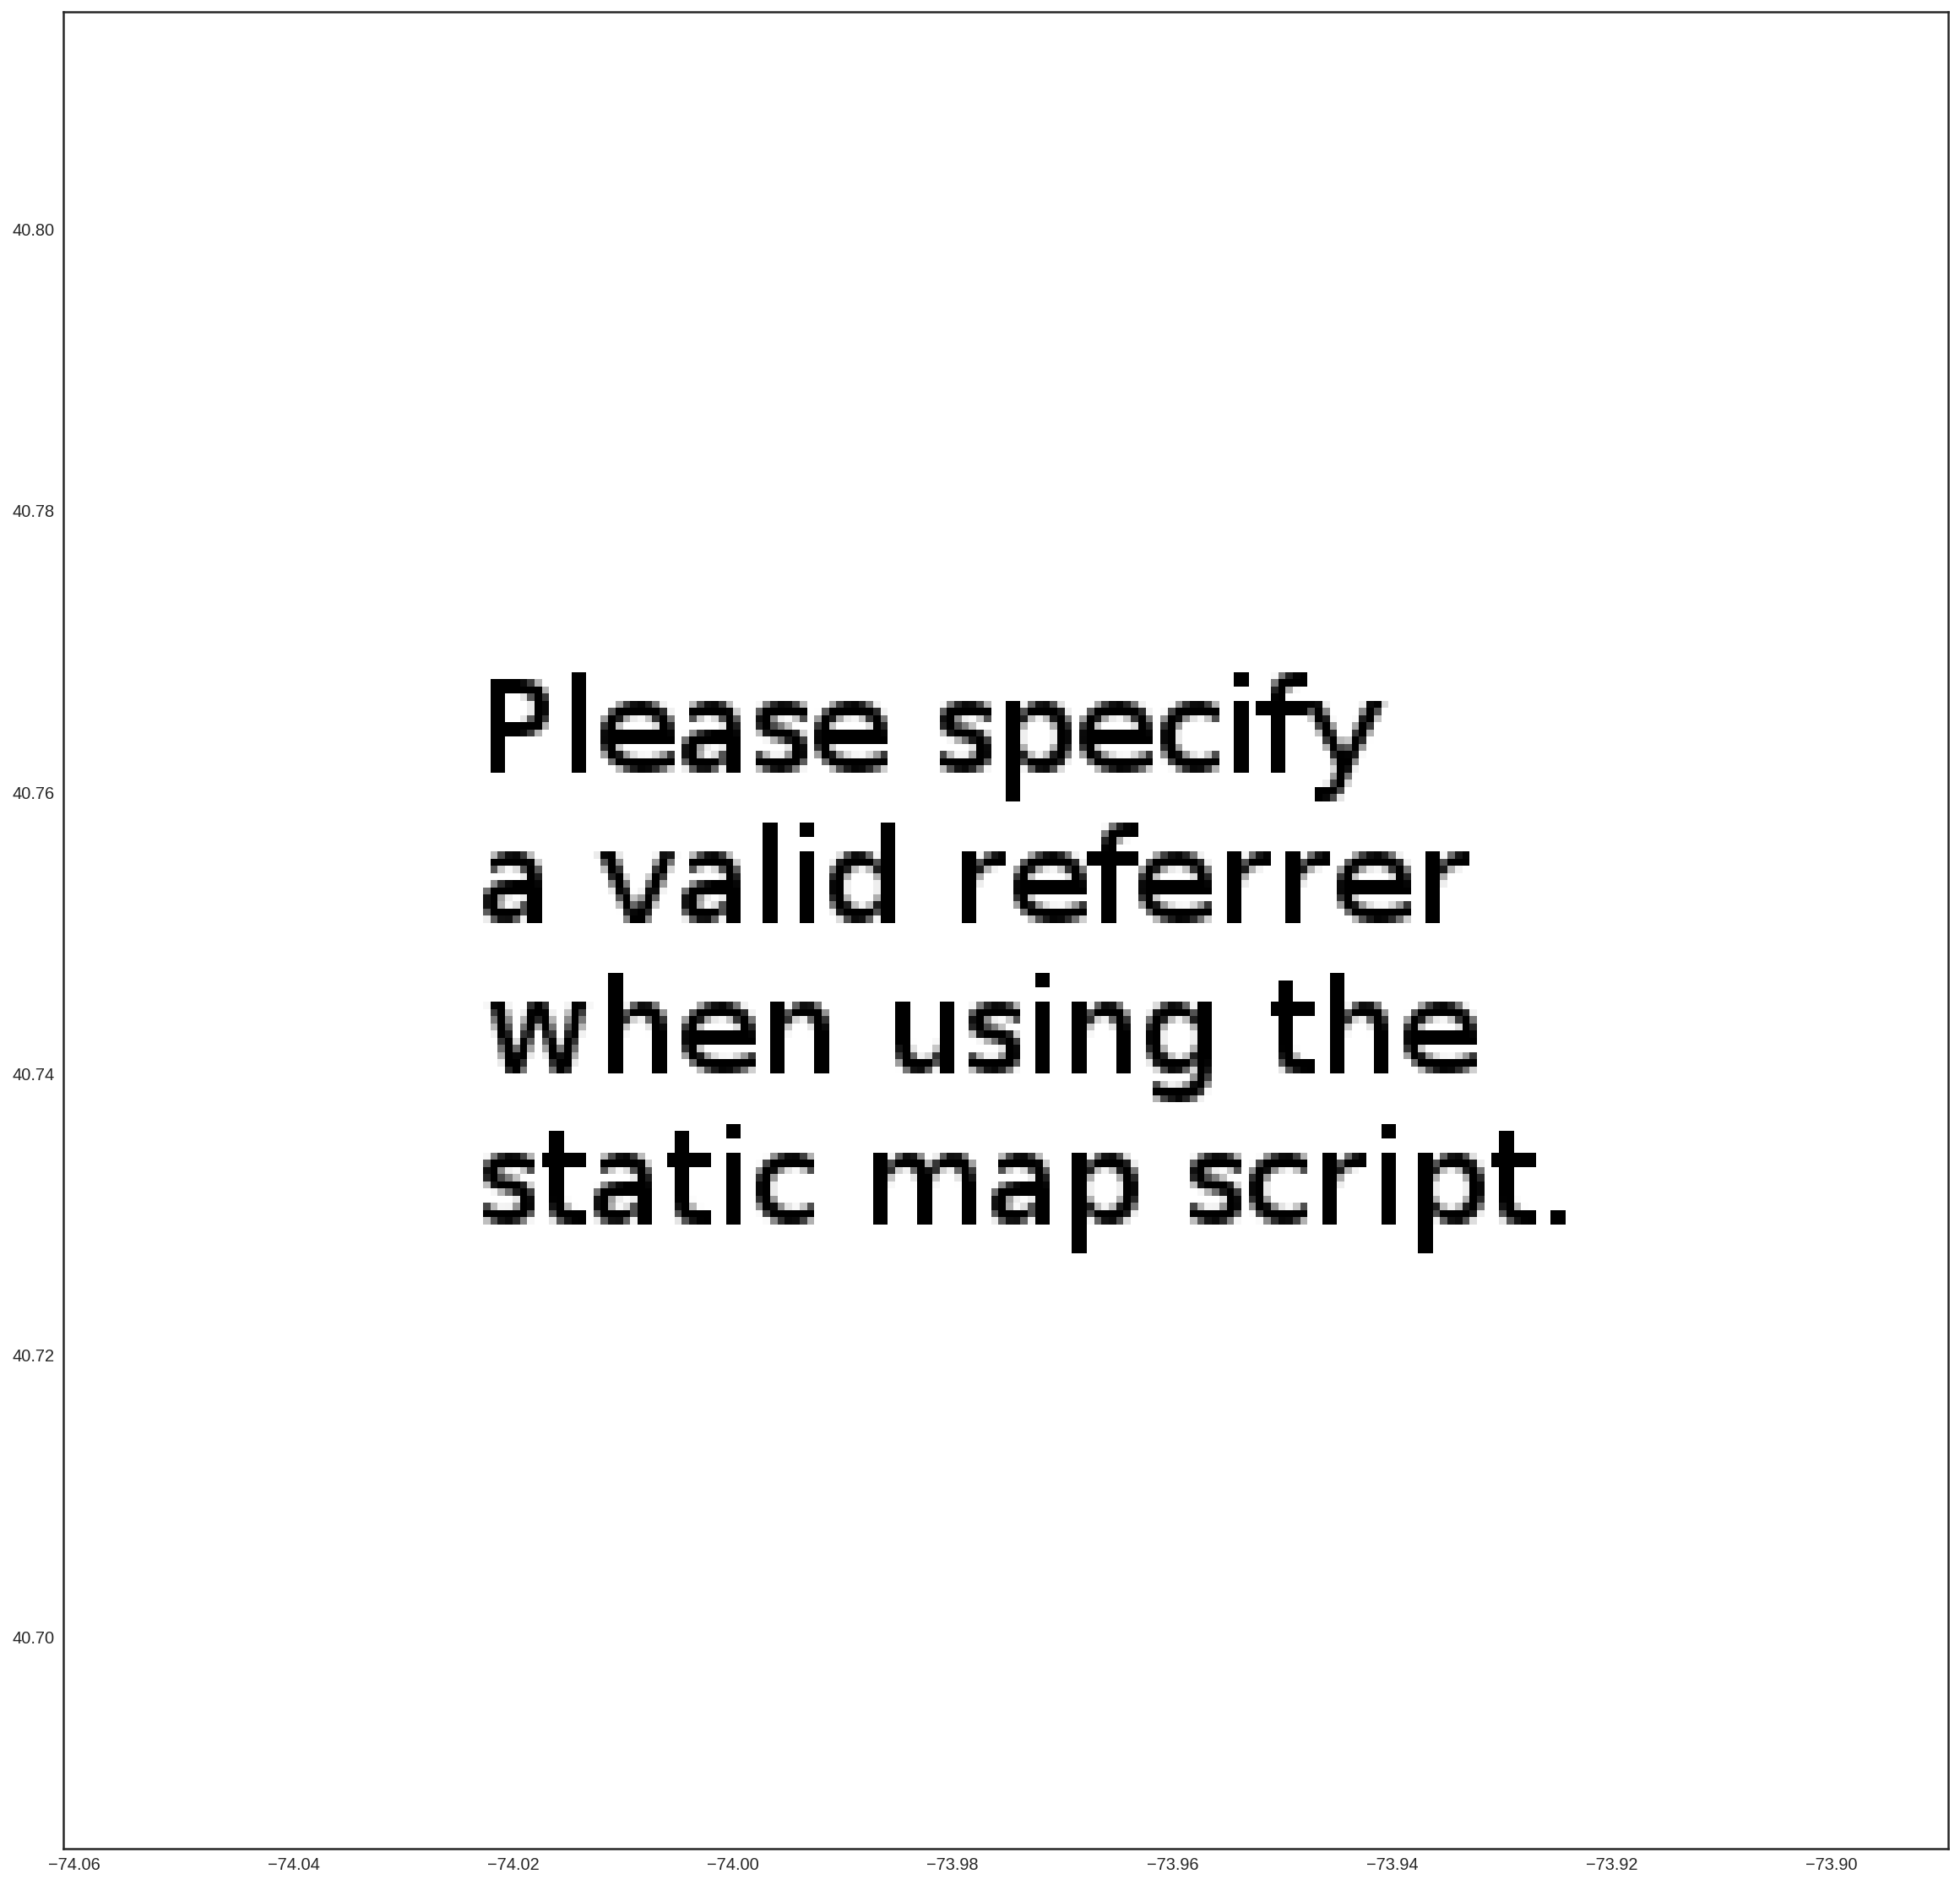

In [52]:
from scipy.spatial import ConvexHull

plt.style.use('seaborn-white')
fig = plt.figure()
fig.set_size_inches(20,20)

empty= pd.DataFrame(columns=['lon','lat'])
geomap(empty, 13, 2,'k',0.1)

# convex hulls for evry cluster 
for k in unique_labels:
  if k>=0:
    xy = data[data['dbscan_cluster']==k][['lon','lat']].reset_index(drop=True)
    try:
      hull = ConvexHull(xy.as_matrix())
      for simplex in hull.simplices:
        plt.plot(xy.iloc[simplex]['lon'], xy.iloc[simplex]['lat'], 'r-', lw=5)
    except:
      pass

plt.show()

### How big are these regions?

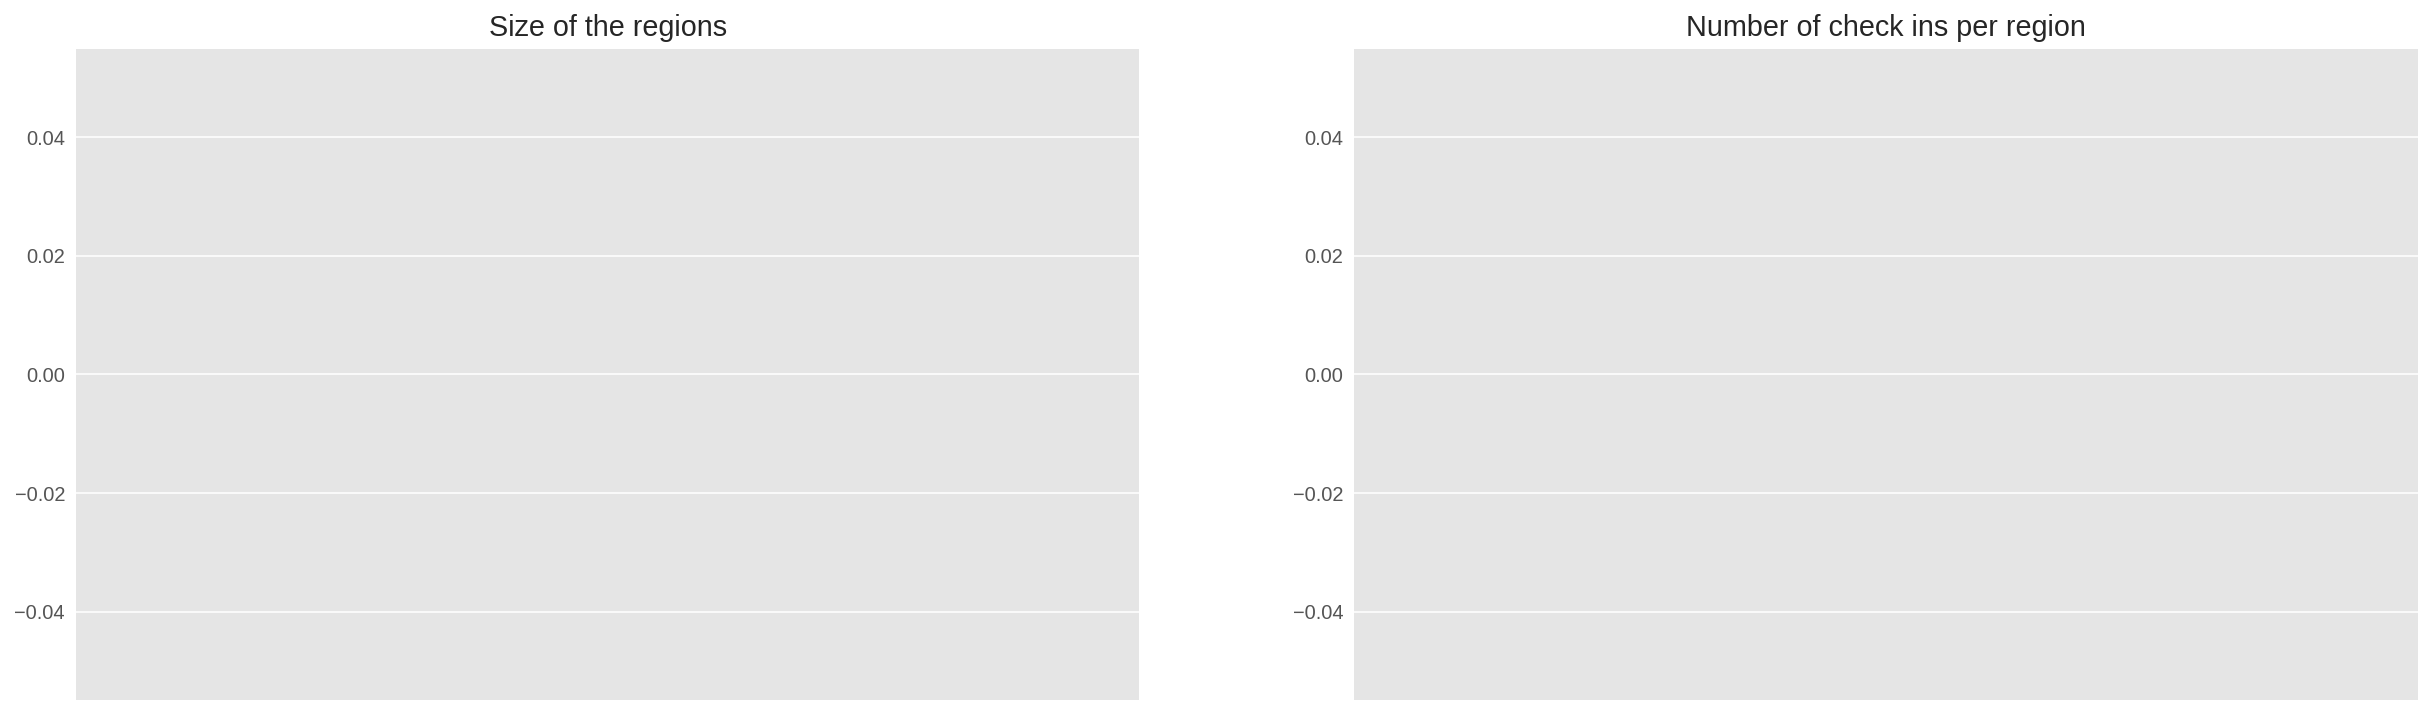

In [53]:
stats = []

for k in unique_labels: # -1 -> 19
  if k >= 0:
    xy = data[data['dbscan_cluster'] == k][['lon', 'lat']].reset_index(drop=True)
    #print xy
    try:
      hull = ConvexHull(xy.as_matrix())
      
      stats.append([k, hull.area, hull.npoints])
    except:
      pass

stats_df = pd.DataFrame(stats, columns=['cluster', 'area', 'count'])

#plotting
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21, 6)

plt.subplot(1, 2, 1)
stats_df = stats_df.sort_values('area', ascending=False).reset_index(drop=True)
stats_df.head()
plt.bar(stats_df.index, stats_df['area'], align='center')
plt.xticks(range(len(stats_df)), stats_df['cluster'])
plt.title('Size of the regions')
plt.subplot(1,2,2)

stats_df = stats_df.sort_values('count', ascending=False).reset_index(drop=True)
plt.bar(stats_df.index, stats_df['count'], align='center')
plt.xticks(range(len(stats_df)), stats_df['cluster'])
plt.title('Number of check ins per region')
plt.show()

### Checking + predicting if this users will be under this area or not ? :Alerting Engines:

Given a user: 4901

In [55]:
from scipy.spatial import Delaunay
hulls = []

for k in unique_labels:
  if k>=0:
    xy = data[data['dbscan_cluster']==k][['lon','lat']].reset_index(drop=True)
    xy = xy.to_numpy()
    try:
      hull = ConvexHull(xy)
      hull_vertices = [ [xy[i][0], xy[i][1]] for i in hull.vertices ]
      hulls.append(hull_vertices)
    except:
      pass

def in_hull(p, convexhull):
  """
  Test if points in `p` are in `hull`
  
  `p` should be a `NxK` coordinates of 'N' points in 'K' dimensions
  `hull` is either a scipy.spatial.Delaunay object or the 'MxK' array of the 
  coordinates of 'M' points in 'K'dimensions for which Delaunay triangulation 
  will be computed
  """
  if not isinstance(convexhull,Delaunay):
    hull = Delaunay(convexhull)
  
  return hull.find_simplex(p)>=0

def location_alert(hulls, lon, lat):
  """
  Determine if the given point is within any of the given convex hulls
  If not, it gives   alert !!!!!!!!!!!!!!!!!!!!!!!!
  """
  result = False
  for k in list(range(len(hulls))):
    result = result or in_hull([lon, lat], hulls[k])
  return (not result)

In [56]:
location_alert(hulls, -73.99, 40.75)

False

In [57]:
location_alert(hulls, -73.99, 43.75)

True